In [ ]:
!pip3 install opencv-python

In [ ]:
!sudo apt install tesseract-ocr
!sudo pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,474 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import pytesseract

import numpy as np
import matplotlib.pyplot as plt

import cv2

Загрузка изображения по ссылке

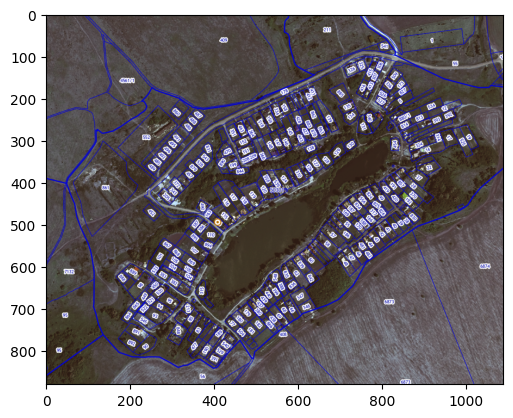

In [ ]:
import urllib.request

# load image via url
url = 'https://github.com/merlin7070/merlin7070/blob/main/1234556.png?raw=true'
url1 = 'https://raw.githubusercontent.com/merlin7070/merlin7070/main/123.png'
url_response = urllib.request.urlopen(url1)
img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

plt.imshow(image)
plt.show()

Предобработка изображения

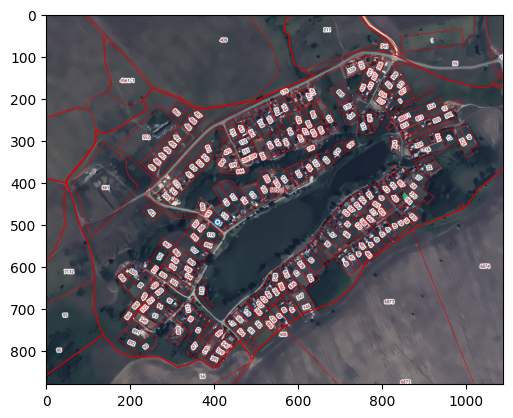

In [ ]:
# color to rgb
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# less noise
denoised_img = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)

plt.imshow(denoised_img)
plt.show()


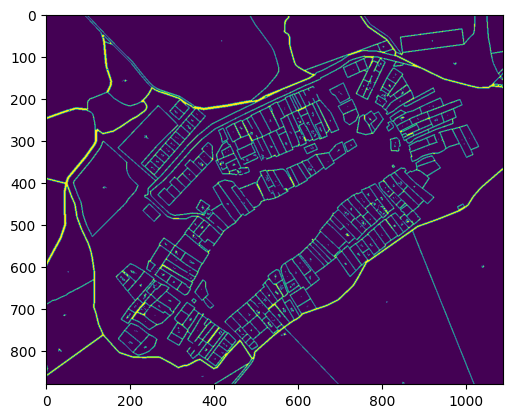

In [ ]:
# get red outline

# get red lines
lower_red = np.array([150, 0,  0], dtype = "uint8")
upper_red = np.array([255, 50,  50], dtype = "uint8")

red_mask = cv2.inRange(denoised_img, lower_red, upper_red)

# dilate
copy = red_mask.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_DILATE,(3,3))
output = cv2.dilate(copy, kernel, iterations=1)
# erode
kernel = cv2.getStructuringElement(cv2.MORPH_DILATE,(2,2))
output = cv2.erode(output, kernel, iterations=1)

# now we have mask with outline
plt.imshow(output)
plt.show()

Получение пустых участков

In [ ]:
# get contours from mask
contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# filter if lenght is too small
cnts = list(filter(lambda cnt: cv2.arcLength(cnt,True)>50, contours))
print("Number of Contours found = " + str(len(contours)))

Number of Contours found = 750


In [ ]:
# process every found area
options = "--psm 1 -c page_separator=''"
output_img = image.copy() # canvas to print output
print_filled = False # flag to print used areas

for index,cnt in enumerate(cnts):
    # make mask for selected area
    canvas = np.uint8(np.zeros((image.shape[0],image.shape[1])))
    cv2.drawContours(canvas, cnts, index, (255, 50, 255), thickness=cv2.FILLED)

    # apply mask
    masked_img = cv2.bitwise_and(image, image, mask = canvas)
    masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)

    # crop selected area -> get image of one area
    x, y, w, h = cv2.boundingRect(cnts[index])
    cropped = masked_img[y:y + h, x:x + w]

    # threshold to get white area with number
    ret, thresh1 = ret,thresh1 = cv2.threshold(cropped,245,255,cv2.THRESH_BINARY)

    # find any object in area
    cnt1, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt1 = list(filter(lambda cnt: cv2.contourArea(cnt)> 3, cnt1))

    # if found any object -> there was pure white area with number
    if len(cnt1)<1: # found any object -> print
      cv2.drawContours(output_img, cnts, index, (0, 255, 0), thickness=2)
    elif print_filled:
      cv2.drawContours(output_img, cnts, index, (0, 0, 255), thickness=2)
    else:
      pass

Вывод результата

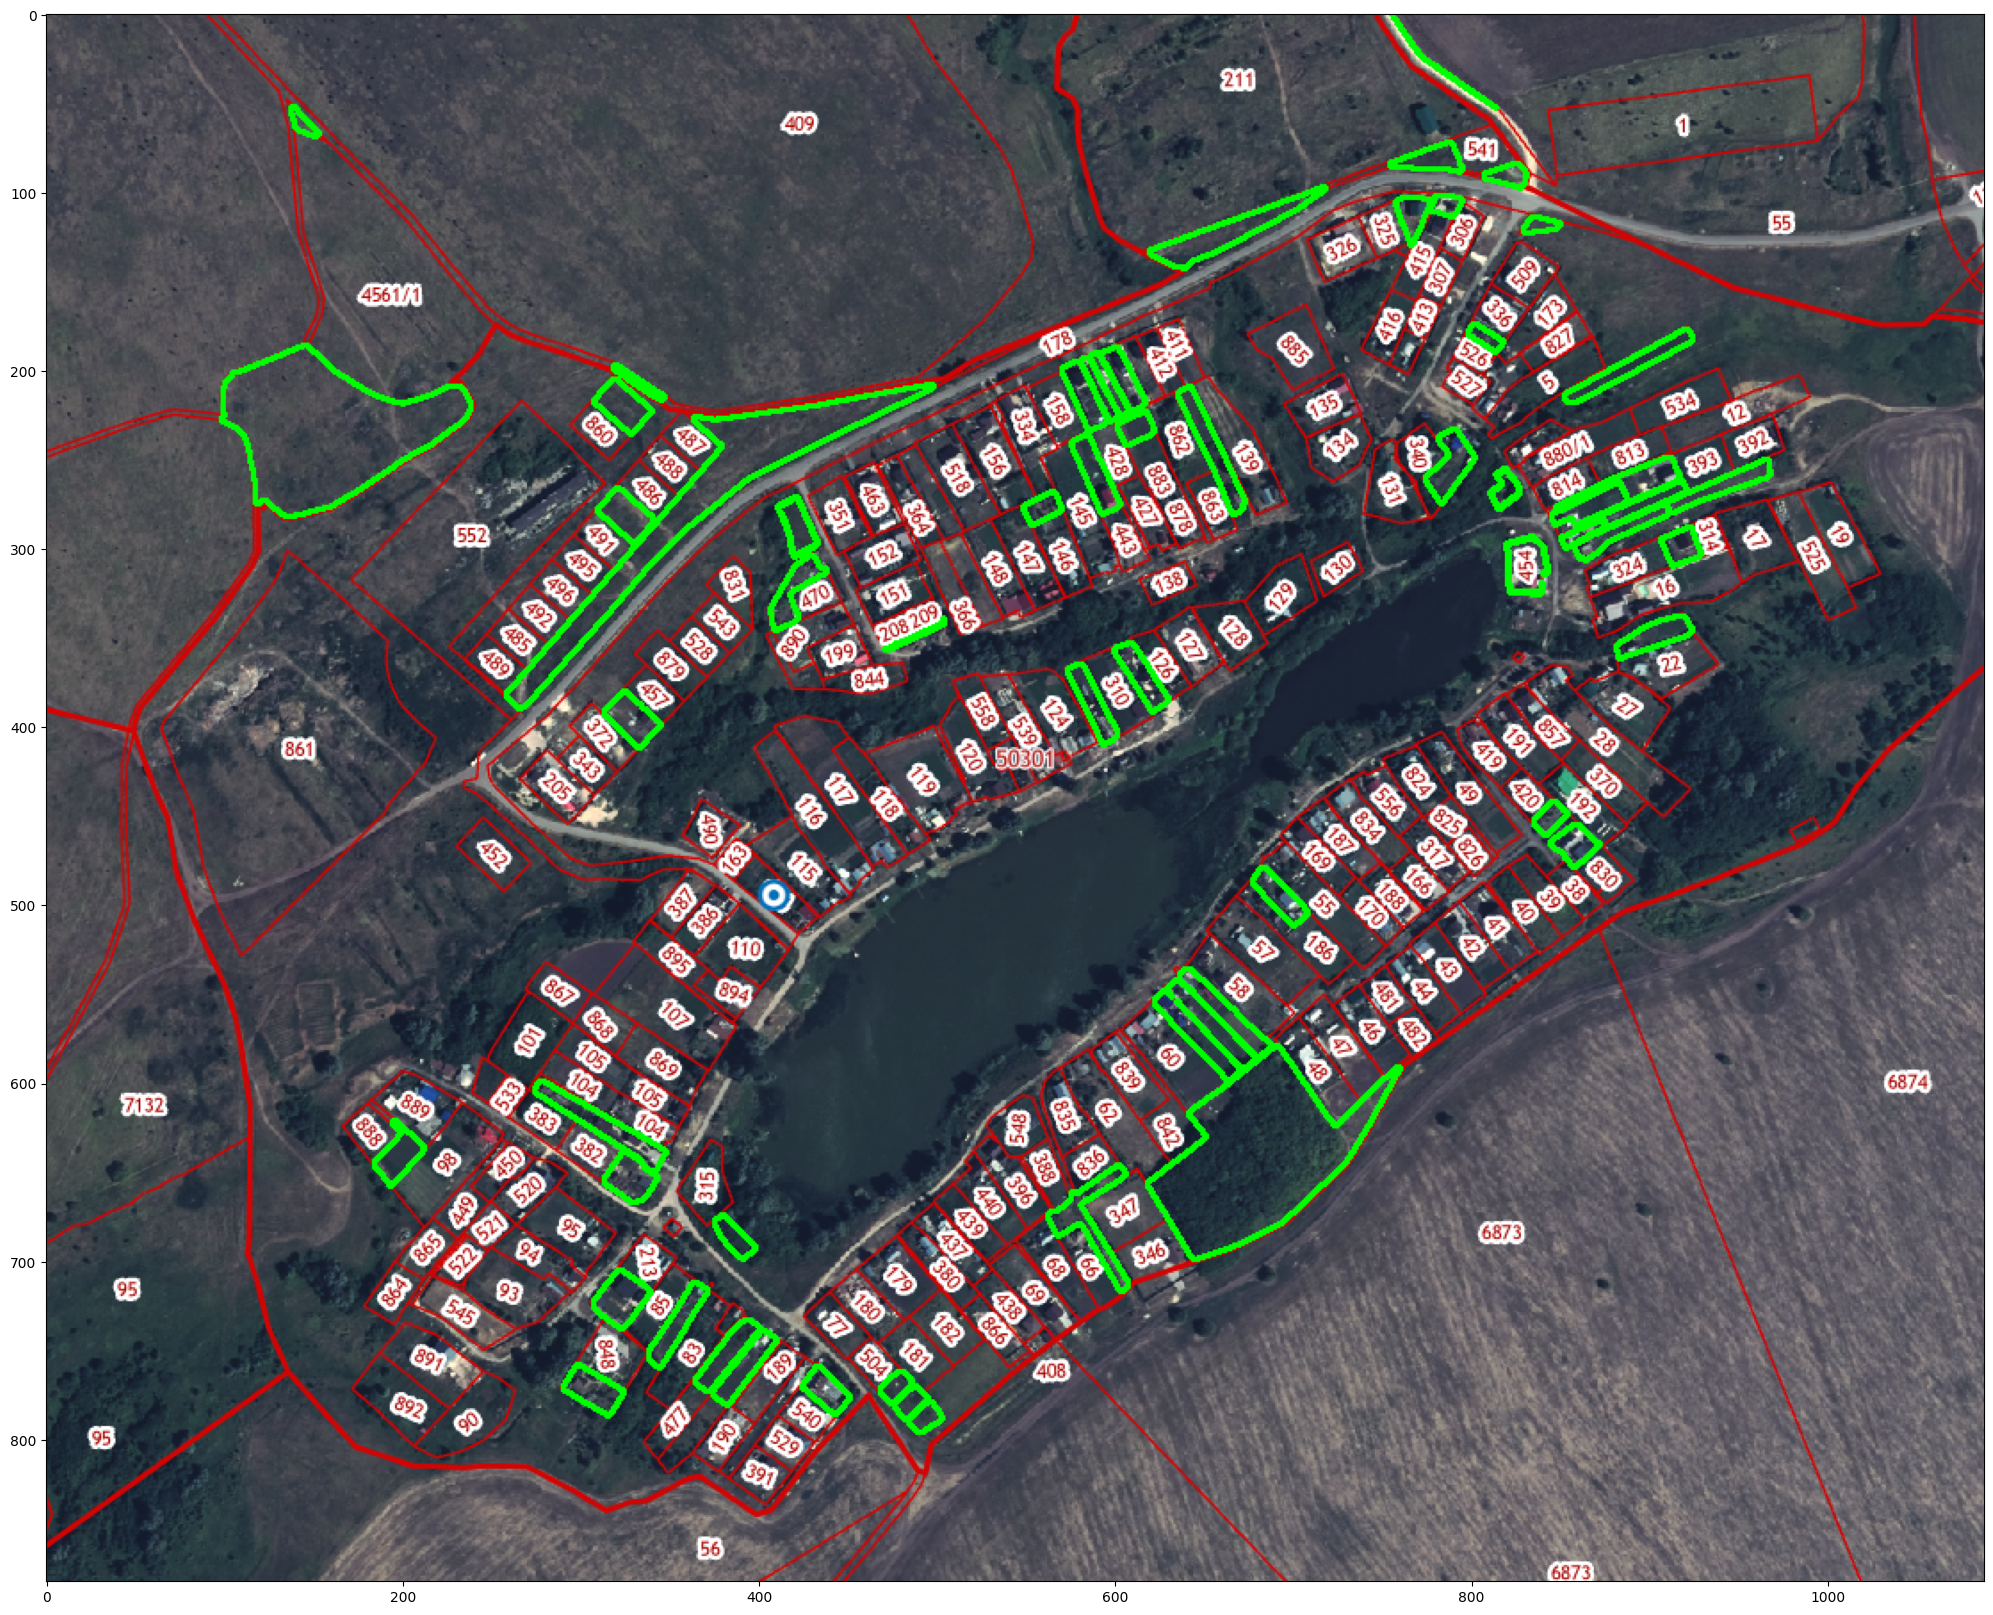

In [ ]:
# print output
# green is free
# blue is not (showed if print_filled is enabled)
plt.figure(figsize = (25, 25))
plt.imshow(output_img)
plt.show()